<a href="https://colab.research.google.com/github/harnalashok/deeplearning-sequences/blob/main/stock_price_prediction_multivariate.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# Last amended: 6th Feb, 2023
# Objective: Apply LSTM for time-series prediction
#            Develop a simple model to predict stock prices

# Ref: https://www.simplilearn.com/tutorials/deep-learning-tutorial/rnn
# https://www.kaggle.com/datasets/akram24/google-stock-price-test


## Call libraries

In [5]:
# 1.0 Call libraries
import numpy as np
import pandas as pd
import tensorflow as tf

# 1.0.1
from sklearn.preprocessing import MinMaxScaler
import matplotlib.pyplot as plt
import pathlib

In [6]:
# 1.0.2 Display multiple outputs from a cell:

from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"


## Mount gdrive

In [7]:
# 2.0 Mount gdrive

from google.colab import drive
drive.mount('/gdrive')

Drive already mounted at /gdrive; to attempt to forcibly remount, call drive.mount("/gdrive", force_remount=True).


In [8]:
# 2.1 Path to data folder:

path = "/gdrive/MyDrive/Colab_data_files/stock_price"

# 2.1.1 Transform to pathlib object:
data_folder=pathlib.Path(path)

## Read train/test data

In [9]:
# 3.0
train = pd.read_csv(data_folder / "Google_Stock_Price_Train.csv")
test = pd.read_csv(data_folder / "Google_Stock_Price_Test.csv")

In [10]:
# 3.0.1
train.head()
print("\n============\n")
train.shape

,Date,Open,High,Low,Close,Volume
0,1/3/2012,325.25,332.83,324.97,663.59,"7,380,500"
1,1/4/2012,331.27,333.87,329.08,666.45,"5,749,400"
2,1/5/2012,329.83,330.75,326.89,657.21,"6,590,300"
3,1/6/2012,328.34,328.77,323.68,648.24,"5,405,900"
4,1/9/2012,322.04,322.29,309.46,620.76,"11,688,800"


(1258, 6)

## Process data


We will use two columns to make predictions. Our columns are`['Open','High']`. Using data on these two columns for the past 60 days, we want to make predictions for the `['Open']` of the next day.

In [11]:
# 4.0 We will only use ['Open','High'] columns for prediction:

tr = train.iloc[:,1:3]
te = test.iloc[:,1:3]
tr.head()
print("\n=============\n")
tr.shape    # (1258, 2)
print("\n=============\n")
te.shape     # (20, 2)

,Open,High
0,325.25,332.83
1,331.27,333.87
2,329.83,330.75
3,328.34,328.77
4,322.04,322.29


(1258, 2)

(20, 2)

In [12]:
# 4.1 Normalize data:
#     Note that we are normalizing two columns together.
#     Later, if we want to un-normalize just one columns,
#     we do need to have a dummy column.

mm = MinMaxScaler(feature_range = (0,1))

# 4.1.0 Transformed output is numpy array"
tr = mm.fit_transform(tr)
te = mm.transform(te)


In [16]:
# 4.1.1 Look at data
tr[:2, :]
print("\n============\n")
te[:2,:]

array([[0.08581368, 0.09640129],
       [0.09701243, 0.09834351]])

array([[0.92955205, 0.94948363],
       [0.94731751, 0.95267709]])

## Organize and reshape data
Prepare data for feeding into LSTM

### Experimental code

Suppose our data is as below and timesteps are 3<br>:
>[23,34],<br>
[56,11],<br>
[12,31],<br>
[77,22],<br>
[50,60],<br>
[10,20],<br>
[65,32],<br>
[40,31],<br>
[32,54]<br>

We want to have following peices:
>[23,34],<br>
[56,11],<br>
[12,31],<br>
Target: 77 <br>

>[56,11],<br>
[12,31],<br>
[77,22],<br>
Target: 50<br>

>[12,31],<br>
[77,22],<br>
[50,60],<br>
Target: 10<br>

>[77,22],<br>
[50,60],<br>
[10,20],<br>
Target: 65<br>

>[50,60],<br>
[10,20],<br>
[65,32],<br>
Target: 40<br>

>[10,20],<br>
[65,32],<br>
[40,31],<br>
Target: 32<br>


`                      

In [18]:
# 5.0 Demo data:
timesteps = 3
data = pd.DataFrame(
                    [
                      [23,34],
                      [56,11],
                      [12,31],
                      [77,22],
                      [50,60],
                      [10,20],
                      [65,32],
                      [40,31],
                      [32,54]
                     ], columns = ['a','b']
                    )
data

,a,b
0,23,34
1,56,11
2,12,31
3,77,22
4,50,60
5,10,20
6,65,32
7,40,31
8,32,54


In [20]:
# 5.1 Organize it : 
xtr = []
ytr = []
for i in range(timesteps,len(data)):
  xtr.append(data.values[i-timesteps:i, :]) 
  ytr.append(data.values[i,0])

In [21]:
# 5.2 Check
xtr    # A list of arrays
print("\n==========\n")
xtr[0].shape   # Each element of shape (3,2)
print("\n==========\n")
ytr

[array([[23, 34],
        [56, 11],
        [12, 31]]), array([[56, 11],
        [12, 31],
        [77, 22]]), array([[12, 31],
        [77, 22],
        [50, 60]]), array([[77, 22],
        [50, 60],
        [10, 20]]), array([[50, 60],
        [10, 20],
        [65, 32]]), array([[10, 20],
        [65, 32],
        [40, 31]])]

(3, 2)

[77, 50, 10, 65, 40, 32]

### Real code


In [24]:
# 6.0
timesteps = 60
X_train = []
y_train = []

for i in range(timesteps,len(tr)):
  X_train.append(tr[i-60:i,:])
  y_train.append(tr[i,0])

In [25]:
# 6.1 Transform list to arrays
X_train = np.array(X_train)
y_train = np.array(y_train)


In [26]:
# 6.2 X_train is an array of arrays:
type(X_train)
print("\n========\n")
X_train.shape
print("\n========\n")
type(X_train[0][:])
print("\n========\n")
X_train[0][:].shape      # (1198, 60) there are 1198 arrays, each of size 60

numpy.ndarray

(1198, 60, 2)

numpy.ndarray

(60, 2)

In [27]:
# 6.3 Reshape, if needed, to : (samples,timesteps,noOfFeatures):
#     Not needed

X_train= np.reshape(X_train, (X_train.shape[0],X_train.shape[1],2))
X_train.shape    # (1198, 60, 2)

(1198, 60, 2)

## Model

In [ ]:
# 7.0
model = tf.keras.Sequential()

In [ ]:
# 7.1 X_train.shape[0] is number of samples:
model.add(tf.keras.layers.Input(shape = (X_train.shape[1], X_train.shape[2])))

In [ ]:
# 7.2
model.add(tf.keras.layers.LSTM(
                                units = 50,
                                return_sequences = True
                               )
         )

In [ ]:
# 7.3
model.add(tf.keras.layers.Dropout(0.2))

In [ ]:
# 7.4
model.add(tf.keras.layers.LSTM(
                               units = 50,
                               return_sequences = True)
                              )

In [ ]:
# 7.5
model.add(tf.keras.layers.Dropout(0.2))

In [ ]:
# 7.6
model.add(tf.keras.layers.LSTM(units = 50))

In [ ]:
# 7.7
model.add(tf.keras.layers.Dropout(0.1))

In [ ]:
# 7.8
model.add(tf.keras.layers.Dense(1))

In [ ]:
# 7.9
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 60, 50)            10600     
                                                                 
 dropout (Dropout)           (None, 60, 50)            0         
                                                                 
 lstm_1 (LSTM)               (None, 60, 50)            20200     
                                                                 
 dropout_1 (Dropout)         (None, 60, 50)            0         
                                                                 
 lstm_2 (LSTM)               (None, 50)                20200     
                                                                 
 dropout_2 (Dropout)         (None, 50)                0         
                                                                 
 dense (Dense)               (None, 1)                 5

## Model comilation and fitting

In [ ]:
# 8.0 Compile:
model.compile(optimizer = "adam", loss = "mse")

In [ ]:
# 9.0
model.fit(
          X_train,y_train,
          batch_size = 32,
          epochs = 100
          )

### Complete code at one place:

In [33]:
# 9.1 Complete code at one place:
if 'model' in locals():
  del model

model = tf.keras.Sequential() 
model.add(tf.keras.layers.Input(shape = (X_train.shape[1], X_train.shape[2])))
model.add(tf.keras.layers.LSTM(
                                units = 50,
                                return_sequences = True
                               )
         )
model.add(tf.keras.layers.Dropout(0.2))
model.add(tf.keras.layers.LSTM(
                               units = 50,
                               return_sequences = True)
                              )
model.add(tf.keras.layers.Dropout(0.2))
model.add(tf.keras.layers.LSTM(units = 50))
model.add(tf.keras.layers.Dropout(0.1))
model.add(tf.keras.layers.Dense(1))
model.summary()
model.compile(optimizer = "adam", loss = "mse")
model.fit(
          X_train,y_train,
          batch_size = 32,
          epochs = 100
          )

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 60, 50)            10600     
                                                                 
 dropout (Dropout)           (None, 60, 50)            0         
                                                                 
 lstm_1 (LSTM)               (None, 60, 50)            20200     
                                                                 
 dropout_1 (Dropout)         (None, 60, 50)            0         
                                                                 
 lstm_2 (LSTM)               (None, 50)                20200     
                                                                 
 dropout_2 (Dropout)         (None, 50)                0         
                                                                 
 dense (Dense)               (None, 1)                 5

## Make predictions

### Prepare test data

In [34]:
# 10.0 Our data:
te.shape   # (20, 2)
tr.shape  # (1258, 2)

(20, 2)

(1258, 2)

In [35]:
# 10.1 Concatenate tr/te:

combined_df = np.vstack([tr, te])
combined_df.shape

(1278, 2)

In [36]:
# 10.2 Data for test predictions:

inputs = combined_df[len(combined_df) - len(te) - 60:]
inputs.shape   # (80,2)

(80, 2)

In [ ]:
# 10.3 Reshape, if rquired
#      Not required
inputs = inputs.reshape(-1,2)
inputs.shape   # (80, 2)

In [37]:
# 11.1 Prepare 'test' timeseries data from inputs data:

X_test = []
for i in range(60,80):
    X_test.append(inputs[i-60:i,:])


In [38]:
# 11.2 Check: 
len(X_test)    # 20
print("\n===========\n")
X_test[0].shape
print("\n===========\n")
X_test = np.array(X_test)
X_test.shape   # (20, 60)

20

(60, 2)

(20, 60, 2)

In [ ]:
# 11.3 Reshape X_test:
#      Not needed. Data already in this shape

X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1],2))
X_test.shape

(20, 60, 1)

### Make predictions

In [39]:
# 12 Make predictions

pred = model.predict(X_test)

print("\n==========\n")
pred
print("\n==========\n")
pred.shape

1/1 [==============================] - 1s 1s/step




array([[0.94359475],
       [0.93993336],
       [0.9426388 ],
       [0.94706446],
       [0.9567988 ],
       [0.968518  ],
       [0.97566783],
       [0.97615224],
       [0.97418207],
       [0.97365844],
       [0.9732412 ],
       [0.97287524],
       [0.9738355 ],
       [0.97516316],
       [0.9804561 ],
       [0.9917551 ],
       [1.005832  ],
       [1.0178225 ],
       [1.0233822 ],
       [1.0097568 ]], dtype=float32)

(20, 1)

In [40]:
# 11.4 Inverse transform:
#      Inverse transform requires that we have
#      data of shape of (n,2), as transform was carried
#      out on data of shape(n,2)
#      Add a dummy IInd columns:

out = np.hstack([pred,pred])

# 11.5 Now inverse transform
pred = mm.inverse_transform(out)
pred

array([[786.3588 , 786.4767 ],
       [784.39056, 784.5161 ],
       [785.8449 , 785.9648 ],
       [788.224  , 788.3346 ],
       [793.4567 , 793.54706],
       [799.75653, 799.8224 ],
       [803.6    , 803.6509 ],
       [803.8604 , 803.9102 ],
       [802.80133, 802.8553 ],
       [802.51984, 802.5749 ],
       [802.29553, 802.3515 ],
       [802.0988 , 802.1555 ],
       [802.61505, 802.6697 ],
       [803.32874, 803.3806 ],
       [806.17395, 806.21484],
       [812.24786, 812.26514],
       [819.815  , 819.80286],
       [826.2606 , 826.22345],
       [829.2493 , 829.2005 ],
       [821.92487, 821.9045 ]], dtype=float32)

## Plotting results

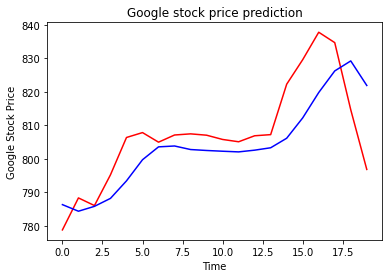

In [41]:
# 12.0 Plot 
real_stock_price = test.values[:, 1]
plt.plot(real_stock_price, color='red', label = "Real Google Stock Price");
plt.plot(pred[:,0], color = 'blue', label = "PRedicted google stock price") ;
plt.title("Google stock price prediction") ;
plt.xlabel("Time") ;
plt.ylabel("Google Stock Price");
plt.show() ;

In [ ]:
################## I am done ##################33

In [ ]:
! pip install attention

In [47]:
from attention import Attention

In [60]:

# 9.1 Complete code at one place:
model1 = tf.keras.Sequential() 
model1.add(tf.keras.layers.Input(shape = (X_train.shape[1], X_train.shape[2])))
model1.add(tf.keras.layers.LSTM(
                                units = 50,
                                return_sequences = True
                               )
         )
model1.add(tf.keras.layers.Dropout(0.2))
model1.add(tf.keras.layers.LSTM(
                               units = 50,
                               return_sequences = True
                              )
          )
model1.add(tf.keras.layers.Dropout(0.2))
model1.add(Attention(50))
model1.add(tf.keras.layers.Dropout(0.1))
model1.add(tf.keras.layers.Dense(1))
model1.summary()
model1.compile(optimizer = "adam", loss = "mse")
model1.fit(
          X_train,y_train,
          batch_size = 32,
          epochs = 100
          )


Model: "sequential_11"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_11 (LSTM)              (None, 60, 50)            10600     
                                                                 
 dropout_11 (Dropout)        (None, 60, 50)            0         
                                                                 
 lstm_12 (LSTM)              (None, 60, 50)            20200     
                                                                 
 dropout_12 (Dropout)        (None, 60, 50)            0         
                                                                 
 attention_6 (Attention)     (None, 50)                7500      
                                                                 
 dropout_13 (Dropout)        (None, 50)                0         
                                                                 
 dense_2 (Dense)             (None, 1)               

In [62]:
pred = model1.predict(X_test)
out = np.hstack([pred,pred])
pred = mm.inverse_transform(out)
# 12.0 Plot 
real_stock_price = test.values[:, 1]
plt.plot(real_stock_price, color='red', label = "Real Google Stock Price");
plt.plot(pred[:,0], color = 'blue', label = "PRedicted google stock price") ;
plt.title("Google stock price prediction") ;
plt.xlabel("Time") ;
plt.ylabel("Google Stock Price");
plt.show() ;

NameError: ignored